In [ ]:
import pandas as pd
import polars as pl
import time
import os
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = {'veganSubs': [], 'nonVeganSubs': [], 'controlSubs': []}
data_path = '/content/drive/MyDrive/Network Science project/reddit_data'


# Loop through all files in the directory
for filename in os.listdir(data_path):
    if any(x in data.keys() for x in filename.split('_')) and ('comments' in filename):
        category = filename.split('_')[0]
        df = pl.read_csv(os.path.join(data_path, filename))
        data[category].extend(df['comment_body'].to_list())

# Because we don't have same amount of comments in each post, we need to fill in the 'shorter'
# columns with 'None' values in order to create a data frame. Because it requires all of the columns
# to be the same length

max_length = max(len(data['veganSubs']), len(data['nonVeganSubs']), len(data['controlSubs']))
for category in data:
    data[category].extend([None] * (max_length - len(data[category])))

combined_df = pl.DataFrame(data)

print(combined_df)

shape: (205_057, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ veganSubs                      ┆ nonVeganSubs                   ┆ controlSubs                    │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ str                            ┆ str                            │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ That's a long time coming      ┆ I kinda wanna fuck it          ┆ Neat                           │
│                                ┆                                ┆                                │
│                                ┆                                ┆                                │
│                                ┆                                ┆ With your system, how …        │
│ Now restaurants need to start  ┆ I was like... don't squeeze    ┆ Tha

In [ ]:
df.head()

comment_id,parent_id,post_id,comment_body,emojis
str,str,str,str,str
"""lmzpj0o""","""t3_1fg4sjz""","""1fg4sjz""","""Those are vegan lions, Instead…",null
"""ln14hx4""","""t3_1fg4sjz""","""1fg4sjz""","""I was just explaining this on …",null
"""lmzo7j2""","""t3_1fg4sjz""","""1fg4sjz""","""This will never not be the fun…",null
"""ln10x3b""","""t3_1fg4sjz""","""1fg4sjz""","""""Hey Marty, thanks again for l…",null
"""ln0k2po""","""t3_1fg4sjz""","""1fg4sjz""","""We commend your scarifies for …",null


In [ ]:
veganSubs_list = combined_df['veganSubs'].drop_nulls()
nonVeganSubs_list = combined_df['nonVeganSubs'].drop_nulls()
controlSubs_list = combined_df['controlSubs'].drop_nulls()

In [ ]:
import re
import spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Define a preprocessing function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove hyperlinks
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove non-alphanumeric characters except spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

def lemmatize_texts(texts, batch_size=50):
    lemmatized_texts = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        lemmatized_texts.append(" ".join([token.lemma_ for token in doc if not token.is_stop]))
    return lemmatized_texts



# Preprocess the combined comments
vegan_processed = veganSubs_list.map_elements(clean_text)
nonVegan_processed = nonVeganSubs_list.map_elements(clean_text)
control_processed = controlSubs_list.map_elements(clean_text)

vegan_processed = lemmatize_texts(vegan_processed)
nonVegan_processed = lemmatize_texts(nonVegan_processed)
control_processed = lemmatize_texts(control_processed)

<ipython-input-6-9647e375a818>:25: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  vegan_processed = veganSubs_list.map_elements(clean_text)
<ipython-input-6-9647e375a818>:26: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  nonVegan_processed = nonVeganSubs_list.map_elements(clean_text)
<ipython-input-6-9647e375a818>:27: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  control_processed = controlSubs_list.map_elements(clean_text)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vegan_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)
nonvegan_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)
control_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)

vegan_matrix = vegan_tfidf.fit_transform(vegan_processed)
vegan_features = vegan_tfidf.get_feature_names_out()

nonvegan_matrix = nonvegan_tfidf.fit_transform(nonVegan_processed)
nonvegan_features = nonvegan_tfidf.get_feature_names_out()

control_matrix = control_tfidf.fit_transform(control_processed)
control_features = control_tfidf.get_feature_names_out()

In [ ]:
vegan_scores = vegan_matrix.mean(axis=0).argsort()
vegan_top20 = vegan_features[vegan_scores[::-1]][0][:20]

nonvegan_scores = nonvegan_matrix.mean(axis=0).argsort()
nonvegan_top20 = nonvegan_features[nonvegan_scores[::-1]][0][:20]

control_scores = control_matrix.mean(axis=0).argsort()
control_top20 = control_features[control_scores[::-1]][0][:20]

In [ ]:
top20_df = pd.DataFrame({'vegan': vegan_top20,
                         'nonVegan': nonvegan_top20,
                         'control': control_top20})

In [ ]:
top20_df

,vegan,nonVegan,control
0,dispense,elimination,moderator
1,practicableall,eliminate,preheat
2,excludea,amount,debate
3,animalfree,glucose,tsp
4,faq,population,domain
5,wholly,constantly,consumption
6,advise,maintain,tbsp
7,denote,unhealthy,contact
8,misunderstanding,consumption,review
9,wfpb,approach,combine




---

# **Grouped Data**



In [ ]:
import os
import polars as pl

# Initialize empty DataFrames for each category
combined_dfs = {
    "veganSubs": pl.DataFrame(),
    "nonVeganSubs": pl.DataFrame(),
    "controlSubs": pl.DataFrame()
}

# Iterate through files in the directory
for filename in os.listdir(data_path):
    for category in combined_dfs.keys():
        if category in filename and "comments" in filename:
            df = pl.read_csv(os.path.join(data_path, filename))

            if "post_id" in df.columns and "comment_body" in df.columns:
                combined_dfs[category] = pl.concat(
                    [combined_dfs[category], df.select(["post_id", "comment_body"])],
                    how="vertical"
                )

# Access the combined DataFrames
vegan_df = combined_dfs["veganSubs"]
non_vegan_df = combined_dfs["nonVeganSubs"]
control_df = combined_dfs["controlSubs"]

In [ ]:
vegan_grouped = vegan_df.group_by('post_id').agg(pl.col('comment_body').str.join(' '))['comment_body']
nonvegan_grouped = non_vegan_df.group_by('post_id').agg(pl.col('comment_body').str.join(' '))['comment_body']
control_grouped = control_df.group_by('post_id').agg(pl.col('comment_body').str.join(' '))['comment_body']

In [ ]:
# Preprocess the combined comments
vegan_processed_grouped = vegan_grouped.map_elements(clean_text)
nonVegan_processed_grouped = nonvegan_grouped.map_elements(clean_text)
control_processed_grouped = control_grouped.map_elements(clean_text)

spacy.require_gpu()
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.max_length = 1200000

vegan_processed_grouped = lemmatize_texts(vegan_processed_grouped)
nonVegan_processed_grouped = lemmatize_texts(nonVegan_processed_grouped)
control_processed_grouped = lemmatize_texts(control_processed_grouped)

<ipython-input-13-d97835d1c570>:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  vegan_processed_grouped = vegan_grouped.map_elements(clean_text)
<ipython-input-13-d97835d1c570>:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  nonVegan_processed_grouped = nonvegan_grouped.map_elements(clean_text)
<ipython-input-13-d97835d1c570>:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  control_processed_grouped = control_grouped.map_elements(clean_text)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vegan_grouped_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)
nonvegan_grouped_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)
control_grouped_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)

vegan_grouped_matrix = vegan_grouped_tfidf.fit_transform(vegan_processed_grouped)
vegan_grouped_features = vegan_grouped_tfidf.get_feature_names_out()

nonvegan_grouped_matrix = nonvegan_grouped_tfidf.fit_transform(nonVegan_processed_grouped)
nonvegan_grouped_features = nonvegan_grouped_tfidf.get_feature_names_out()

control_grouped_matrix = control_grouped_tfidf.fit_transform(control_processed_grouped)
control_grouped_features = control_grouped_tfidf.get_feature_names_out()

In [ ]:
vegan_grouped_scores = vegan_grouped_matrix.mean(axis=0).argsort()
vegan_grouped_top20 = vegan_grouped_features[vegan_grouped_scores[::-1]][0][:20]

nonvegan_grouped_scores = nonvegan_grouped_matrix.mean(axis=0).argsort()
nonvegan_grouped_top20 = nonvegan_grouped_features[nonvegan_grouped_scores[::-1]][0][:20]

control_grouped_scores = control_grouped_matrix.mean(axis=0).argsort()
control_grouped_top20 = control_grouped_features[control_grouped_scores[::-1]][0][:20]

In [ ]:
top20_grouped = pd.DataFrame({'vegan': vegan_grouped_top20,
                         'nonVegan': nonvegan_grouped_top20,
                         'control': control_grouped_top20})

In [ ]:
top20_grouped

,vegan,nonVegan,control
0,innocent,moo,potluck
1,sheep,waygu,miracle
2,morality,maple,rotisserie
3,slavery,mr,restriction
4,slave,a5,disgusting
5,religion,mid,rarely
6,jail,edge,barely
7,fuel,center,complain
8,wool,stain,sink
9,genocide,candy,condiment


# Network

In [ ]:
tokenized_vegan_grouped = [comment.split() for comment in vegan_processed_grouped]
tokenized_nonvegan_grouped = [comment.split() for comment in nonVegan_processed_grouped]
tokenized_control_grouped = [comment.split() for comment in control_processed_grouped]

In [ ]:
tokenized_vegan_grouped = [word for comments in tokenized_vegan_grouped for word in comments if len(word) > 3]
tokenized_nonvegan_grouped = [word for comments in tokenized_nonvegan_grouped for word in comments if len(word) > 3]
tokenized_control_grouped = [word for comments in tokenized_control_grouped for word in comments if len(word) > 3]

In [ ]:
tokenized_vegan_grouped = [item for item in tokenized_vegan_grouped if not item.isdigit()]
tokenized_nonvegan_grouped = [item for item in tokenized_nonvegan_grouped if not item.isdigit()]
tokenized_control_grouped = [item for item in tokenized_control_grouped if not item.isdigit()]

In [ ]:
text_vegan = max(vegan_grouped, key=len)
text_nonvegan = max(nonvegan_grouped, key=len)
text_control = max(control_grouped, key=len)

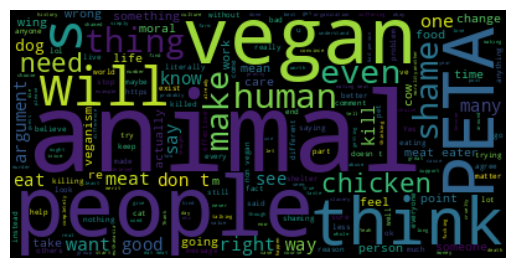

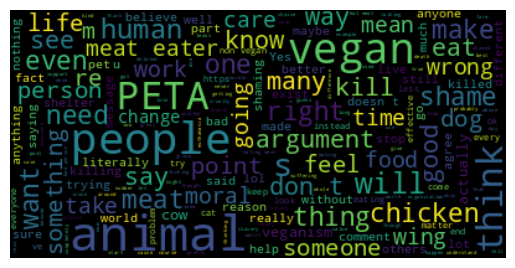

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(text_vegan)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text_vegan)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

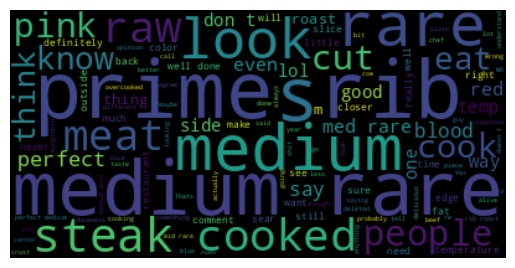

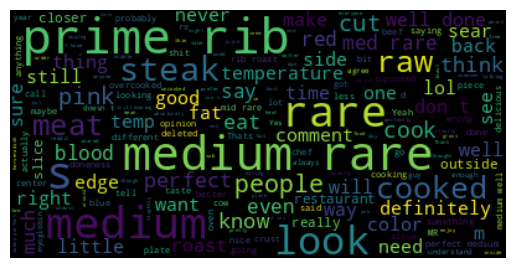

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(text_nonvegan)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text_nonvegan)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

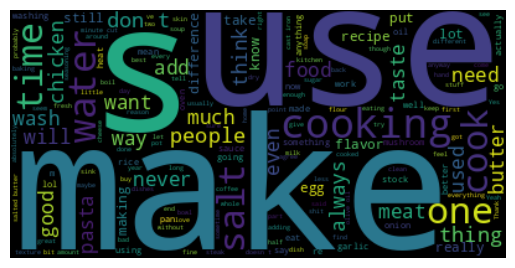

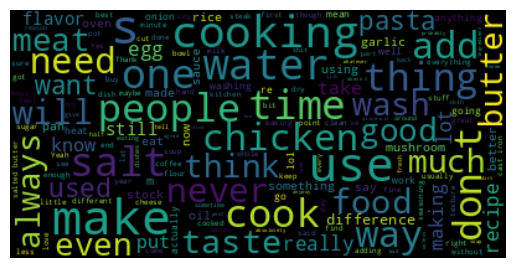

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(text_control)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text_control)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

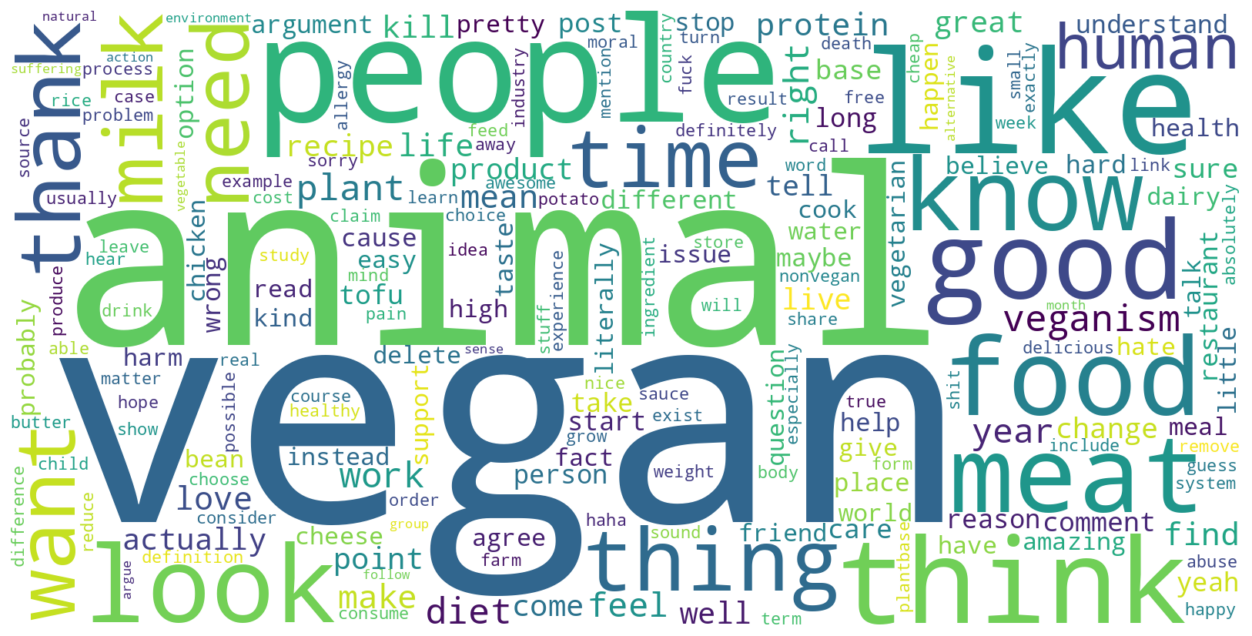

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def create_large_wordcloud(words, filename="wordcloud.png", max_words=200, width=1600, height=800, background_color="white"):
    word_counts = Counter(words)

    # 2. Create the WordCloud object
    wordcloud = WordCloud(
        max_words=max_words,
        width=width,
        height=height,
        background_color=background_color,
        # contour_width=3,  # Optional: adds a contour around the words
        # contour_color='steelblue', # Optional: sets the color of the contour
        # font_path='/path/to/your/font.ttf' # Optional: if you need a specific font
    ).generate_from_frequencies(word_counts)  # Use frequencies

    # 3. Display the generated image:
    plt.figure(figsize=(width/100, height/100), dpi=100) # Adjust figure size for large images
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # 4. Save the image:
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save at high DPI

    plt.show()
create_large_wordcloud(tokenized_vegan_grouped, filename="vegan_large_wordcloud.png")

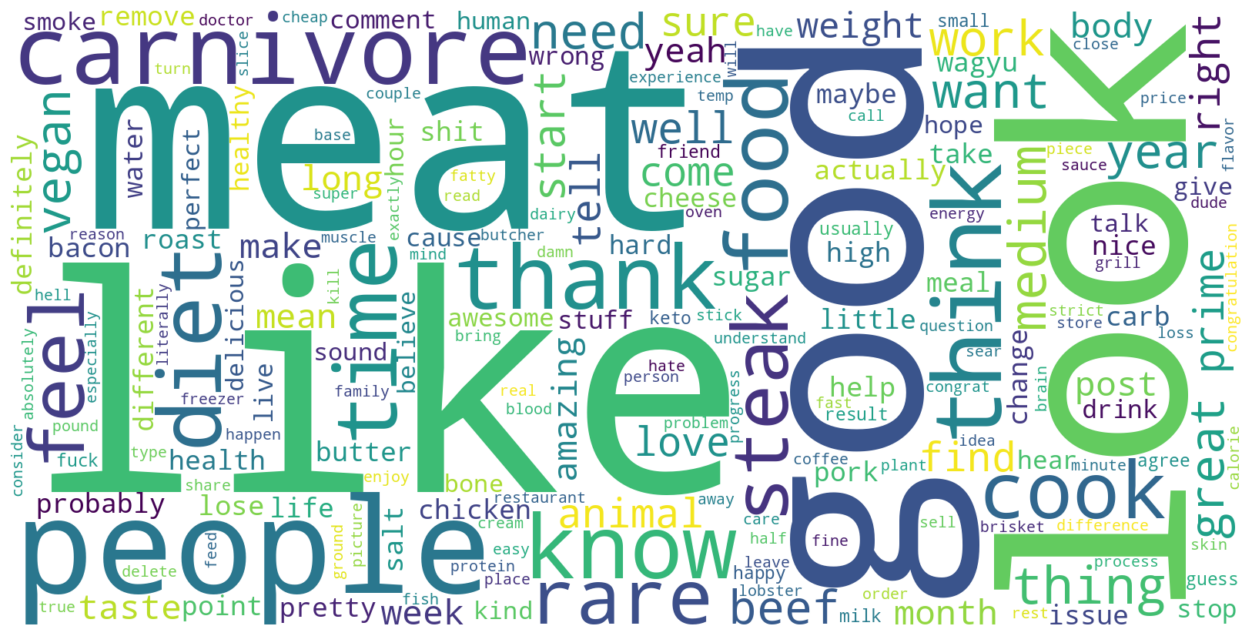

In [ ]:
create_large_wordcloud(tokenized_nonvegan_grouped, "nonvegan_large_wordcloud.png")

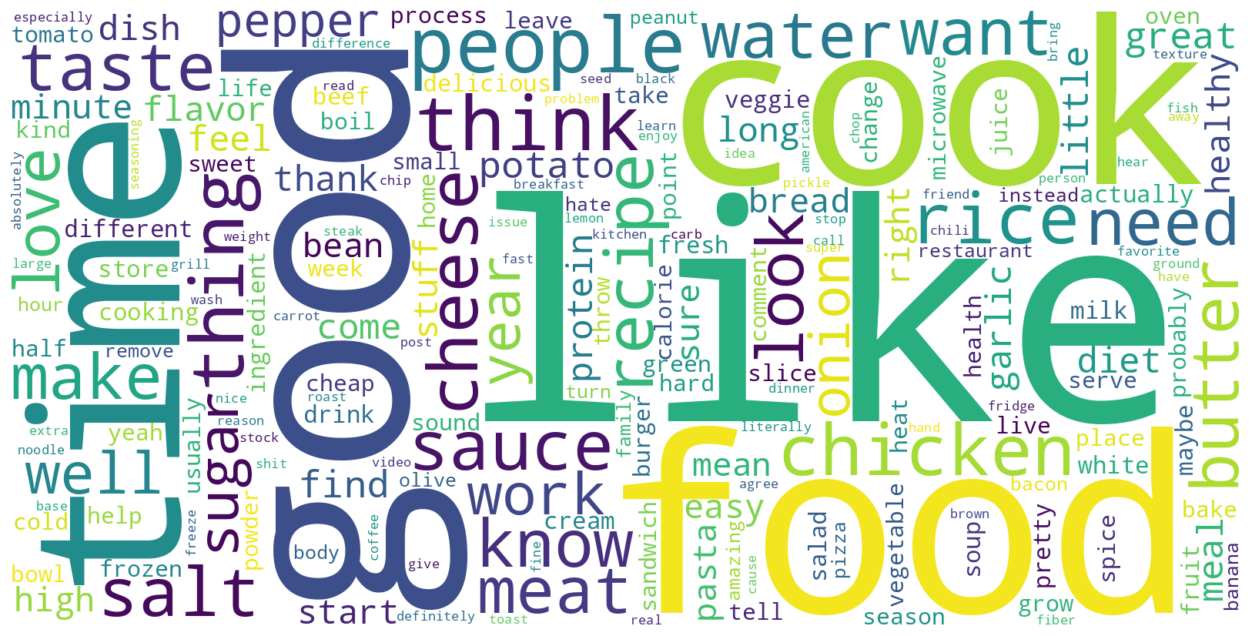

In [ ]:
create_large_wordcloud(tokenized_control_grouped, "control_large_wordcloud.png")

Codes below create semantic network where two nodes have edge if they are sequential in a comment. For this reason, we are going to use **ungrouped** version the comments.

In [ ]:
### Filter comments with less than 3 words

vegan_network_list = [comment for comment in vegan_processed if len(comment.split()) > 2]
nonvegan_network_list = [comment for comment in nonVegan_processed if len(comment.split()) > 2]
control_network_list = [comment for comment in control_processed if len(comment.split()) > 2]

In [ ]:
def remove_short_words(comment):
    # Remove words of length 1 or 2
    return re.sub(r'\b\w{1,2}\b', '', comment).strip()

# Apply the function to all comments
vegan_network_list = [remove_short_words(comment) for comment in vegan_network_list]
nonvegan_network_list = [remove_short_words(comment) for comment in nonvegan_network_list]
control_network_list = [remove_short_words(comment) for comment in control_network_list]

In [ ]:
import networkx as nx
from collections import defaultdict

G_vegan = nx.Graph()
vegan_edges = defaultdict(int)

for comment in vegan_network_list:
# Build edges and track weights
  for word1, word2 in zip(comment.split(), comment.split()[1:]):
      # Increment weight for existing or new edge
      vegan_edges[(word1, word2)] += 1

# Add weighted edges to the graph
G_vegan.add_weighted_edges_from([(w1, w2, weight) for (w1, w2), weight in vegan_edges.items()])

In [ ]:
G_nonvegan = nx.Graph()
nonvegan_edges = defaultdict(int)

for comment in nonvegan_network_list:
# Build edges and track weights
  for word1, word2 in zip(comment.split(), comment.split()[1:]):
      # Increment weight for existing or new edge
      nonvegan_edges[(word1, word2)] += 1

# Add weighted edges to the graph
G_nonvegan.add_weighted_edges_from([(w1, w2, weight) for (w1, w2), weight in nonvegan_edges.items()])

In [ ]:
G_control = nx.Graph()
control_edges = defaultdict(int)

for comment in control_network_list:
# Build edges and track weights
  for word1, word2 in zip(comment.split(), comment.split()[1:]):
      # Increment weight for existing or new edge
      control_edges[(word1, word2)] += 1

# Add weighted edges to the graph
G_control.add_weighted_edges_from([(w1, w2, weight) for (w1, w2), weight in control_edges.items()])

In [ ]:
threshold = 3

vegan_filtered_edges = [(u, v, d) for u, v, d in G_vegan.edges(data=True) if d["weight"] >= threshold]
Gvegan_filtered = nx.Graph()
Gvegan_filtered.add_edges_from(vegan_filtered_edges)

In [ ]:
nonvegan_filtered_edges = [(u, v, d) for u, v, d in G_nonvegan.edges(data=True) if d["weight"] >= threshold]
Gnonvegan_filtered = nx.Graph()
Gnonvegan_filtered.add_edges_from(nonvegan_filtered_edges)

In [ ]:
control_filtered_edges = [(u, v, d) for u, v, d in G_control.edges(data=True) if d["weight"] >= threshold]
Gcontrol_filtered = nx.Graph()
Gcontrol_filtered.add_edges_from(control_filtered_edges)

In [ ]:
vegan_pr =  nx.pagerank(Gvegan_filtered)

In [ ]:
nonvegan_pr = nx.pagerank(Gnonvegan_filtered)

In [ ]:
control_pr = nx.pagerank(Gcontrol_filtered)

In [ ]:
# Extract top 20 words per dictionary
def get_top_words(pr_dict, n=20):
    return [word for word, _ in sorted(pr_dict.items(), key=lambda x: x[1], reverse=True)[:n]]

# Create a DataFrame
top_20pr = pd.DataFrame({
    "vegan": get_top_words(vegan_pr),
    "nonvegan": get_top_words(nonvegan_pr),
    "control": get_top_words(control_pr)
})

top_20pr


,vegan,nonvegan,control
0,not,not,not
1,vegan,eat,like
2,animal,like,eat
3,people,meat,food
4,eat,good,good
5,like,people,cook
6,meat,look,add
7,food,carnivore,people
8,think,fat,use
9,good,diet,time
